In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy.integrate import dblquad
import scipy.stats as stats

In [3]:
# Import modules
import os
import arviz as az
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Import functions
from cmdstanpy import CmdStanModel
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

# Create ./stan folder if does not exists
if not os.path.exists("./stan/lev4"):
    os.mkdir("./stan/lev4")

In [4]:
from mpmath import mp
mp.dps = 50

In [5]:
def prior_kernel(s,t):
    return np.exp(-((t-s)/5)**2)+0.0001*(s==t)
sigma = 1
T = np.linspace(1, 288, 288)
K = np.fromfunction(np.vectorize(lambda s, t: prior_kernel(T[s], T[t])), (T.shape[0], T.shape[0]), dtype=int)


In [6]:
T0=pd.read_csv("chain_fixed.csv") #from the sample with sigma=1, L=5, alpha=1
T0,_=stats.mode(T0[500:], axis=0)
T0=T0.flatten().tolist()

In [7]:
def get_K0():
        tau = np.where(T0==1)[0]
        K_tau=K[:, tau]
        K_tau_tau = K[tau[:, None], tau]
        
        if np.linalg.det(K_tau_tau)==0:
            K_tau_tau = K_tau_tau+0.0001*np.eye(len(tau))
            
        return K- np.dot(np.dot(K_tau, np.linalg.inv(K_tau_tau)), K_tau.T)
K0=get_K0()+np.eye(288)*0.00001

In [8]:
df=pd.read_csv("average_curves.csv",index_col="idx")
df

,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
idx,,,,,,,,,,,,,,,,,,,,,
pat_number,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,...,150.000000,151.000000,152.000000,153.000000,154.000000,155.000000,156.000000,157.000000,158.000000,159.000000
severity,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
constancy,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
age,58.000000,59.000000,62.000000,65.000000,65.000000,70.000000,66.000000,74.000000,58.000000,74.000000,...,68.000000,49.000000,51.000000,66.000000,45.000000,74.000000,67.000000,59.000000,34.000000,72.000000
gender,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,...,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,-0.981659,-1.076615,-1.332550,-1.058805,-0.923807,-1.109480,-1.743754,-1.184359,-1.359995,-1.107242,...,-1.485589,-1.074087,-1.003103,-0.996204,-1.740179,-1.447827,-1.043098,-1.684661,-1.077221,-1.393487
284,-0.993531,-1.078280,-1.332549,-1.044116,-0.923762,-1.109441,-1.743714,-1.217882,-1.360021,-1.116414,...,-1.486356,-1.074077,-1.002612,-0.994606,-1.740226,-1.445859,-1.042748,-1.684662,-1.077203,-1.393533
285,-0.997926,-1.079618,-1.332558,-1.019142,-0.923818,-1.109399,-1.743523,-1.224489,-1.360155,-1.127783,...,-1.487368,-1.074091,-1.003404,-0.994287,-1.740254,-1.440550,-1.042608,-1.684662,-1.077191,-1.393537


In [9]:
# matching to face data availability:
df_levodopa = pd.read_csv('levodopa_data.csv')
df = pd.read_csv('average_curves.csv',index_col='idx')

x = df.iloc[7:,df_levodopa['Pat Number'].astype(int)]
y = df.iloc[1,df_levodopa['Pat Number'].astype(int)]

<BarContainer object of 10 artists>

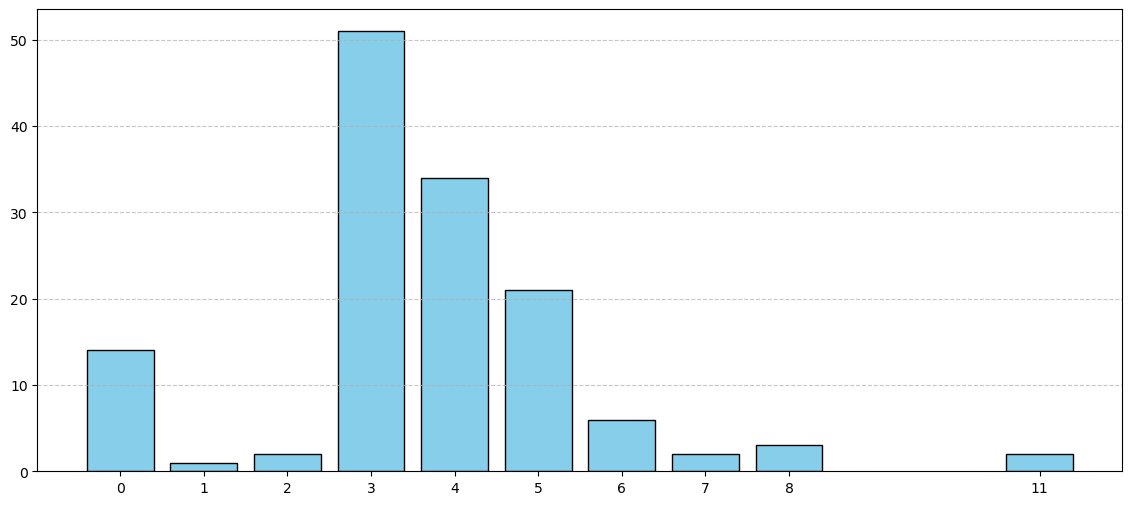

In [10]:

unique_values, counts = np.unique(df_levodopa["Levodopa Dosis"], return_counts=True)

# Plot histogram
plt.figure(figsize=(14, 6))
plt.xticks(unique_values) 
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.bar(unique_values, counts, color='skyblue', edgecolor='black')


In [11]:
y23 = np.copy(y)
y23[y == 1] = 0
y23[y == 2] = 1
y23[y == 3] = 1
np.unique(y23)

array([0., 1.])

In [12]:
#lev_g=np.percentile(df_levadopa["Levadopa Dosis"],[50,100],axis=0)

In [13]:
lev_g=np.ones(136)
lev_g[df_levodopa["Levodopa Dosis"]>=5]=2
lev_g=lev_g.astype(int)

In [14]:
np.unique(df_levodopa["Levodopa Dosis"])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 11], dtype=int64)

## Mixed model with random effects on levadopa treatments 
Let the model be $$Y_{ij}=\int_{T} x_i(t) \beta(t)dt= \int_{t} x_i(t) \theta(t) dt + \int_{T}  x_i(t) \gamma_j(t) dt+ \varepsilon_i$$
such that we consider a random effect specific for the age of the patients. Namely:
$$ \theta|\mu,\sigma^{2}, T_{0} \sim GP(0,\sigma^{2}K^{0})$$ 
$$ \gamma_j  \sim \mathcal{N}(0, \sigma_0^{2}K^{0}) \quad j=1,2\text{ random effect}$$
$$ \varepsilon_i \sim \mathcal{N} (0, \sigma^2)$$

The covariates are:
- functional variable $x_i(t)$  $\quad i=1:159$ ,$\quad t=1:288$
- variable $\lambda_{i} = \mathbb{1}_{\text{lev doses of pat i }  \geq 5 }$  $\quad i=1:159$






In [14]:
# Set sigma and sigma0 to 1
mix = """
data {
  int<lower=1> N;       // Number of observations
  int<lower=1> T;       // Number of time points
  matrix[N, T] x;       // Predictor matrix
  vector[N] y;          // Response vector
  int<lower=1> J;       // Number of groups
  array[N] int <lower=1, upper=J> group; // Group indicator for each observation
  matrix[T, T] K0;
  vector[T] mu;
  real <lower=0.01> sigma;
  real <lower=0.01> sigma0;
  
}

parameters {
  vector[T] theta;      // Coefficients for theta
  matrix[T, J] gamma;   // Coefficients for gamma (group-specific effects)

}

model {
  // Priors
  theta ~ multi_normal(mu, K0);         // Prior for theta
  for (j in 1:J) {
    gamma[, j] ~ multi_normal(mu, K0);  // Prior for each gamma_j
  }

  // Likelihood
  for (i in 1:N) {
    real mu1;
    mu1 = dot_product(x[i], theta) + dot_product(x[i], gamma[, group[i]]);  // Model prediction for observation i
    y[i] ~ normal(mu1, sigma);   // Likelihood of observation i
  }
}


"""

# Write stan model to file
stan_file = "./stan/lev4/mix.stan"
with open(stan_file, "w") as f:
    print(mix, file=f)

# Compile stan model
mix= CmdStanModel(stan_file=stan_file)

00:44:44 - cmdstanpy - INFO - compiling stan file C:\Users\Silvia\Desktop\23-24\BAYES\progetto\stan\lev4\mix.stan to exe file C:\Users\Silvia\Desktop\23-24\BAYES\progetto\stan\lev4\mix.exe
00:45:37 - cmdstanpy - INFO - compiled model executable: C:\Users\Silvia\Desktop\23-24\BAYES\progetto\stan\lev4\mix.exe


In [15]:

data = {
    "N": len(y23),
    "T": x.shape[0],
    "x": np.transpose(x),
    "y": y23,
    "J": 2,
    "group": lev_g,
    "K0": K0,
    "mu": np.zeros(288),
    "sigma": 1, 
    "sigma0": 1,
}  
mix_fit = mix.sample(data=data, chains=2,parallel_chains=2, adapt_delta=0.9, iter_warmup=50, iter_sampling=400)


# Convert to arviz data type
mix_data = az.from_cmdstanpy(mix_fit)

00:45:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

19:10:37 - cmdstanpy - INFO - CmdStan done processing.


19:10:38 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 400 iterations at max treedepth (100.0%)
	Chain 2 had 400 iterations at max treedepth (100.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [16]:
mix_data = az.from_cmdstanpy(mix_fit)

In [17]:
mix_data.to_netcdf('./stan/lev4/output_file.nc')

'./stan/lev4/output_file.nc'

C:\Users\Silvia\Documents\Anaconda\lib\site-packages\arviz\plots\traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (288), generating only 20 plots
  warnings.warn(


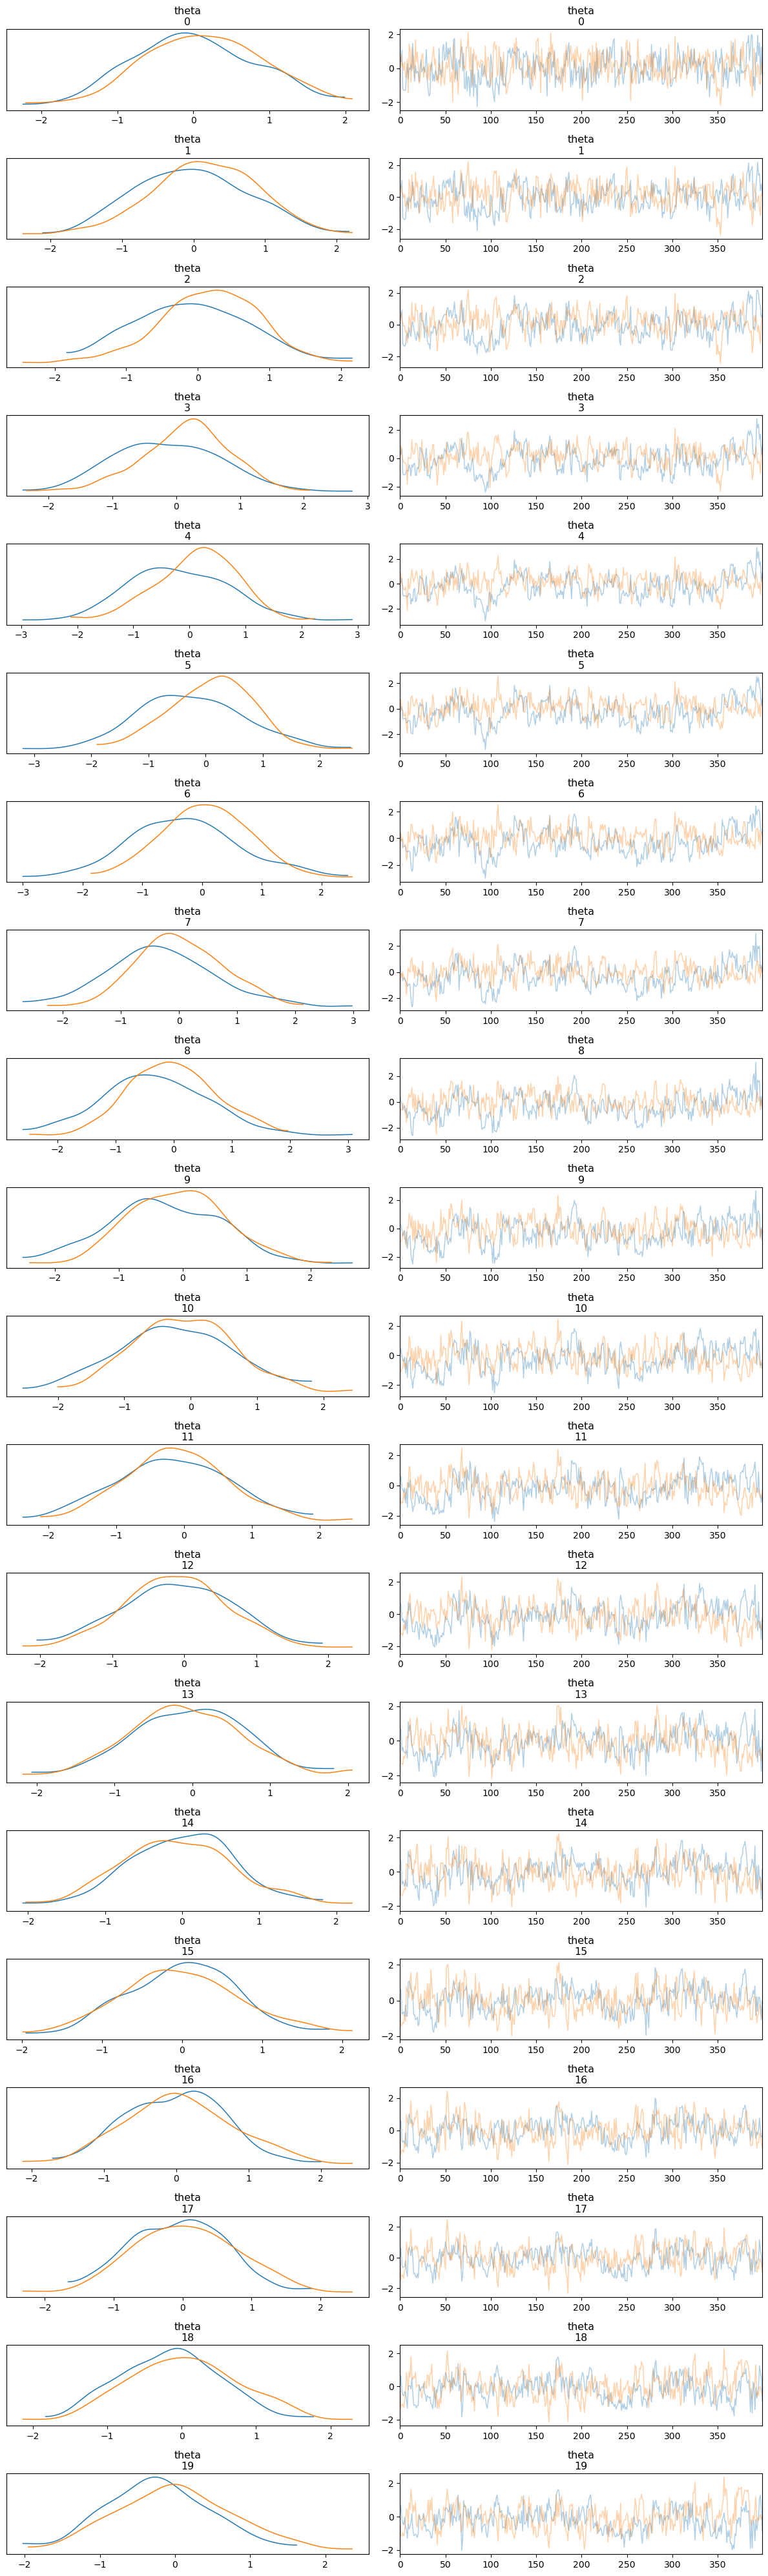

In [19]:
az.plot_trace(mix_data, var_names=[ "theta"], compact=False)
plt.tight_layout()
#plt.savefig('./stan/lev/trace_plot_gamma0.pdf') 
plt.show()

C:\Users\Silvia\Documents\Anaconda\lib\site-packages\arviz\plots\traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (576), generating only 20 plots
  warnings.warn(


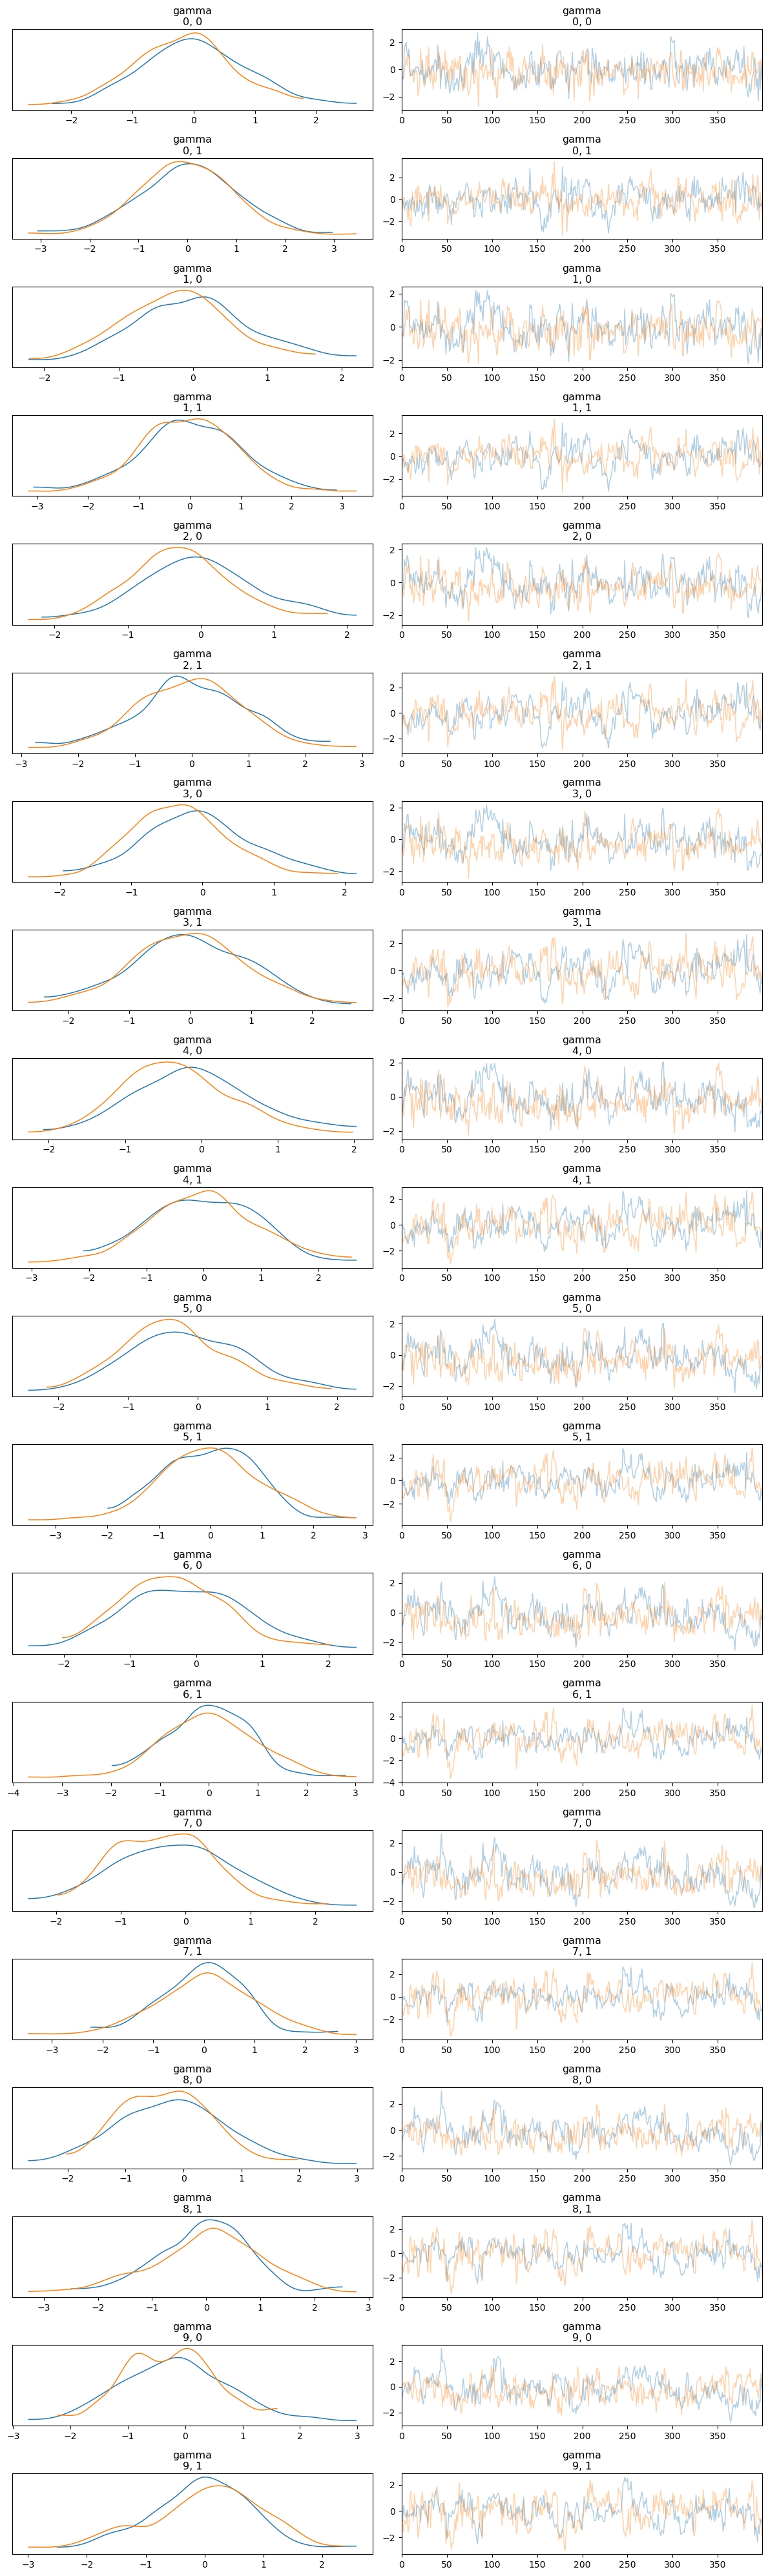

In [20]:
az.plot_trace(mix_data, var_names=[ "gamma"], compact=False)
plt.tight_layout()
#plt.savefig('./stan/lev/trace_plot_gamma0.pdf') 
plt.show()

In [16]:
#mix_data=az.from_netcdf('./stan/lev4/output_file.nc')
gamma=np.array(mix_data.posterior.gamma)[1]
theta=np.array(mix_data.posterior.theta)[1]
theta_hat=np.mean(theta[200:], axis=0)
gamma_hat=np.mean(gamma[200:,:], axis=0)

In [17]:
gamma.shape

(400, 288, 2)

In [18]:
def compute_predictions(new_data):
    predictions = []
    for i in range(136):
        integral_fix = np.dot(theta_hat, new_data.iloc[i,:])
        integral0 = np.dot(gamma_hat[:,int(lev_g[i])-1],new_data.iloc[i,:])
        predictions.append(integral_fix + integral0 )
       
    return np.array(predictions)


In [19]:
fitted=compute_predictions(x.T)

In [20]:
logit_fitted = scipy.special.expit(fitted)
labels = np.zeros(len(fitted))
ones= np.where(logit_fitted >0.5)[0]
labels[ones] = np.ones(len(ones)) 
acc = np.sum(labels==y23)/len(y23)

In [21]:
acc

0.6544117647058824

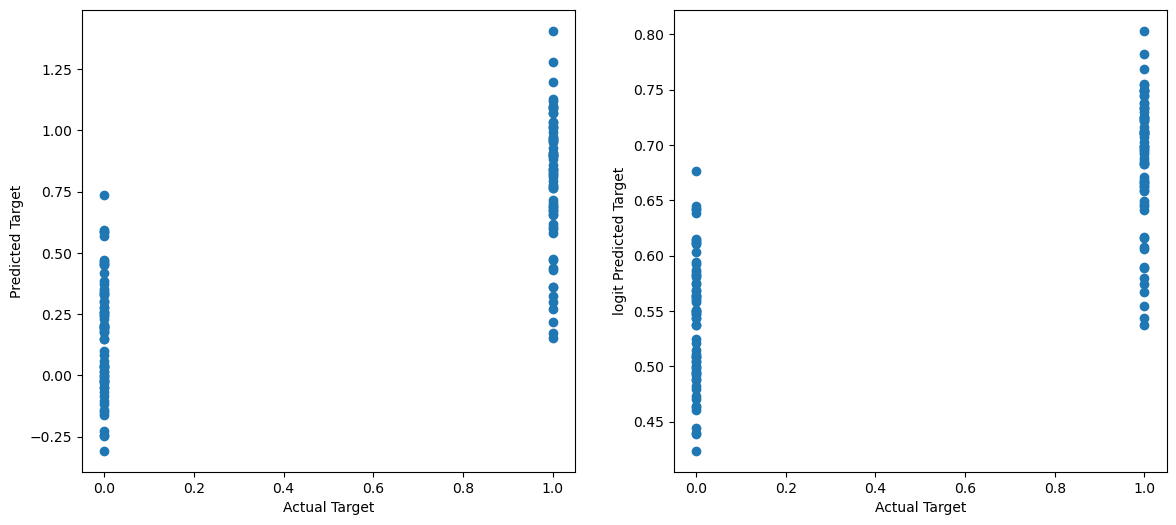

In [22]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(y23,fitted)
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.subplot(1, 2,2)
logit_fitted = scipy.special.expit(fitted)
plt.scatter(y23,logit_fitted)
plt.xlabel('Actual Target')
plt.ylabel('logit Predicted Target')
plt.savefig('./stan/lev4/fit.pdf') 

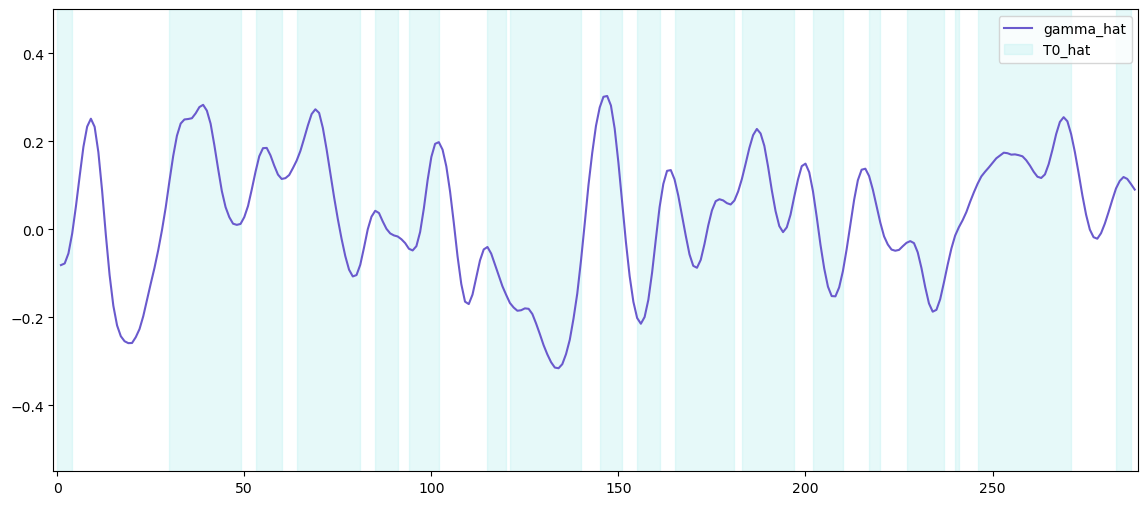

In [24]:
T0_hat = [i + 1 for i, val in enumerate(T0) if val == 1]
plt.figure(figsize=(14, 6))
plt.plot(T,gamma_hat[:,1], label='gamma_hat', color='slateblue')


change_indices = np.where(np.diff(T0) != 0)[0]
if T0[0] == 1:
    change_indices = np.insert(change_indices, 0, 0)
if T0[-1] == 1:
    change_indices = np.append(change_indices, len(T0) - 1)

x_intervals = change_indices.reshape(-1, 2)
y_intervals = np.array([[-0.55,0.5]] * len(x_intervals))

# Plot the intervals
for x_interval, y_interval in zip(x_intervals[0:len(x_intervals)-2], y_intervals[0:len(y_intervals)-2]):
    plt.fill_betweenx(y=y_interval, x1=x_interval[0], x2=x_interval[1], alpha=0.3, color='paleturquoise')
plt.fill_betweenx(y=y_intervals[-1], x1=x_intervals[-1][0], x2=x_intervals[-1][1], alpha=0.3, color='paleturquoise', label='T0_hat')
plt.xlim(-1, 289)
plt.ylim(-0.55,0.5)
plt.legend()
plt.show()